In [14]:
# import numpy as np
import os
from glob import glob
import scipy.io as sio
from skimage.io import imread, imsave
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
from time import time
import argparse
import ast
import imutils
import random
import math
from scipy.interpolate import interp2d
# from phase2.predictor import PosPrediction
import cv2
from phase2.api_ import PRN

from utils.render import render_texture


prn = PRN(is_dlib = True)

In [15]:
def FaceSwap_DL(prn, image, ref_image):
    # read image
    [h, w, _] = image.shape

    #-- 1. 3d reconstruction -> get texture. 
    pos = prn.process(image) 
    vertices = prn.get_vertices(pos)
    image = image/255.
    texture = cv2.remap(image, pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
    
    #-- 2. Texture Editing
    # change whole face(face swap)    # texture from another image or a processed texture
    ref_pos = prn.process(ref_image)
    ref_image = ref_image/255.
    ref_texture = cv2.remap(ref_image, ref_pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
    ref_vertices = prn.get_vertices(ref_pos)
    new_texture = ref_texture#(texture + ref_texture)/2.

    #-- 3. remap to input image.(render)
    vis_colors = np.ones((vertices.shape[0], 1))
    face_mask = render_texture(vertices.T, vis_colors.T, prn.triangles.T, h, w, c = 1)
    face_mask = np.squeeze(face_mask > 0).astype(np.float32)
    
    new_colors = prn.get_colors_from_texture(new_texture)
    new_image = render_texture(vertices.T, new_colors.T, prn.triangles.T, h, w, c = 3)
    new_image = image*(1 - face_mask[:,:,np.newaxis]) + new_image*face_mask[:,:,np.newaxis]

    # Possion Editing for blending image
    vis_ind = np.argwhere(face_mask>0)
    vis_min = np.min(vis_ind, 0)
    vis_max = np.max(vis_ind, 0)
    center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))

    output = cv2.seamlessClone((new_image*255).astype(np.uint8), (image*255).astype(np.uint8), (face_mask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)
    
    return output


In [16]:
path = "../Data/"
image = cv2.imread(path+'Face1.jpg')
ref_image = cv2.imread(path+'Face2.jpg')

output = swapDL(prn, image, ref_image)

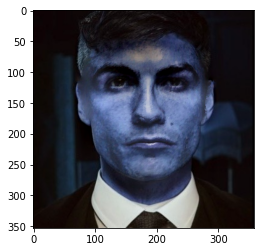

In [18]:
plt.imshow(output)